<a href="https://colab.research.google.com/github/kacper-dobrow/tensorflow-course/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with tensorflow + Milestone Project 3: BitPredict

Project to predict tomorrow's BTC price based on historical data

## Get data

In [50]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-11-14 11:56:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-11-14 11:56:47 (14.1 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv.1’ saved [178509/178509]



## Importing time series with Pandas

In [51]:
# Import with pandas
import pandas as pd
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"], # treat the "Date" column as dates
                 index_col=["Date"]) # index by the date column
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [53]:
# How many samples
len(df)

2787

2787 samples is not much in case of a deep learning model

In [54]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df.rename(columns={"Closing Price (USD)": "Price"})["Price"]) # Doing it the same way Daniel did produces an error. .rename() method needs to be called on a DataFrame and not Series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


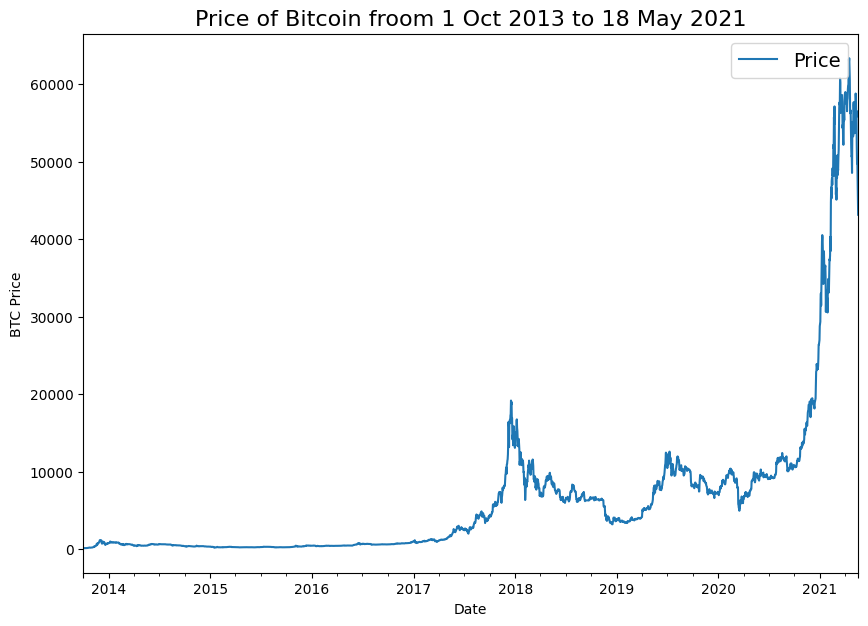

In [55]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series with CSV module instead of Pandas

When not using Pandas

In [56]:
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip 1st line (gets rid of column names)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1],  "%Y-%m-%d")) # get the date from the line as date not string
    btc_price.append(float(line[2])) # get the price as float

# View 1st 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

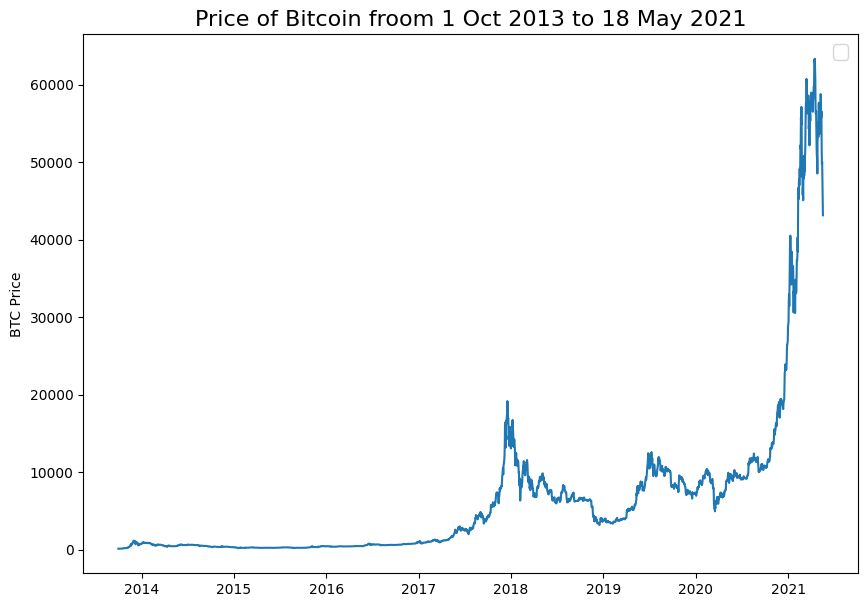

In [57]:
# Plot from CSV
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin froom 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Format data part 1: Create train and test split

### Creating train and test data the wrong way (data leakage)

In [58]:
# Get the date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

In [59]:
# Wrong way to make train/test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=.2, random_state=42)

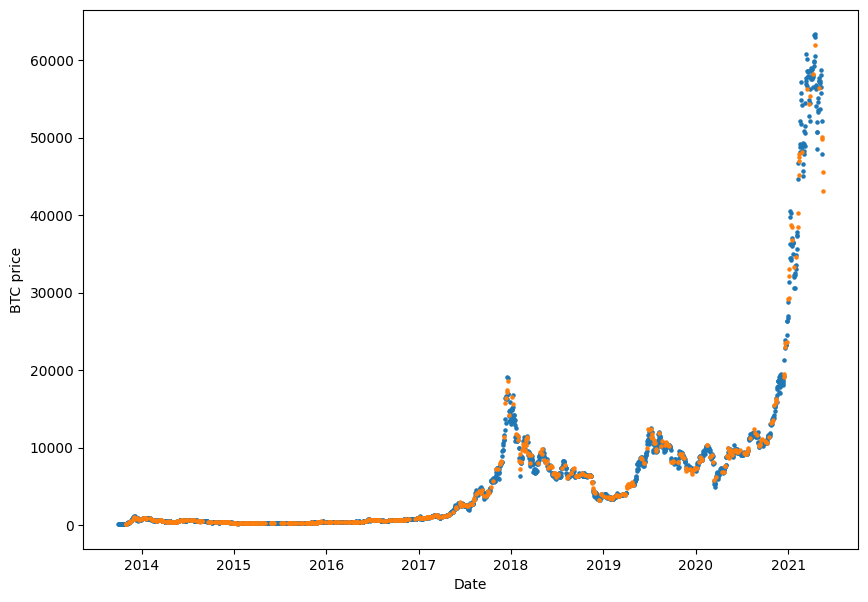

In [60]:
# Plot wrong splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

### Create train and test split the right way

In [61]:
# Create train and test splits
split_size = int(0.8*len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]
# Create test data split
X_test, y_test = timesteps[split_size:], prices[split_size:]

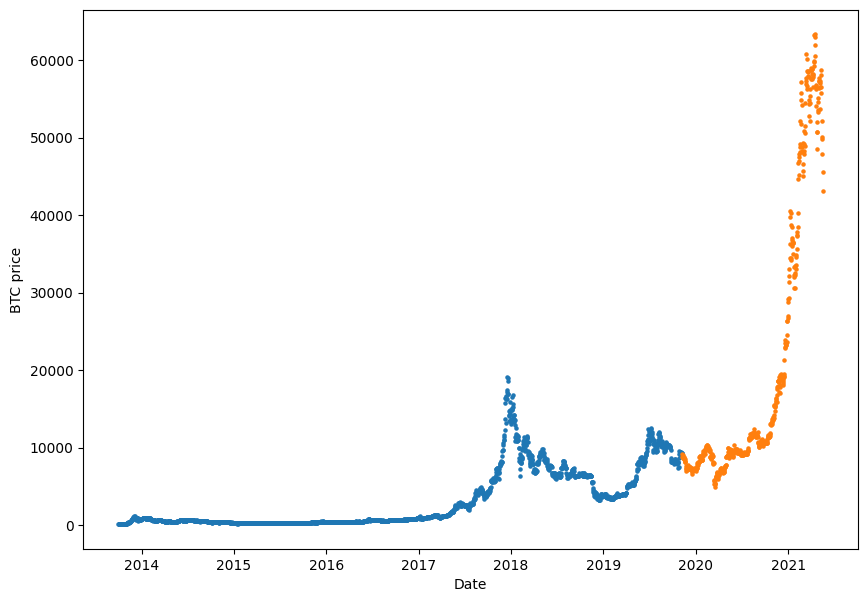

In [62]:
# Plot
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC price")
plt.show();

## Create plotting function

In [63]:
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps against values
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

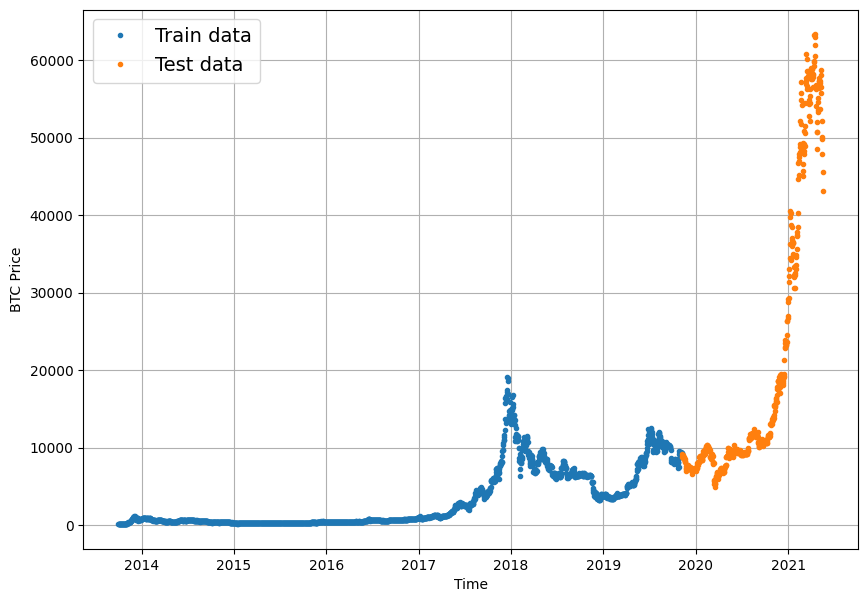

In [64]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling

Terms:
* Horizon - number of timesteps into the future we're going to project
* Window size - number of timesteps to be used when predicting the horizon

Experiments:
0. Naive model (baseline)
1. Dense model, horizon = 1, window = 7
2. Dense model, horizon = 1, window = 30
3. Dense modesl, horizon = 7, window = 30
4. Conv1D
5. LSTM
6. Dense with multivariate data
7. N-BEATs Algorithm
8. Ensemble - multiple models optimized on different loss functions
9. Future prediction model
10. Dense with turkey data

In [65]:
346/426

0.812206572769953

## Model 0: Naive forecast baseline

We just assume the next value is the same as the current one

In [66]:
# Create a naive forecast
naive_forecast = y_test[:-1]

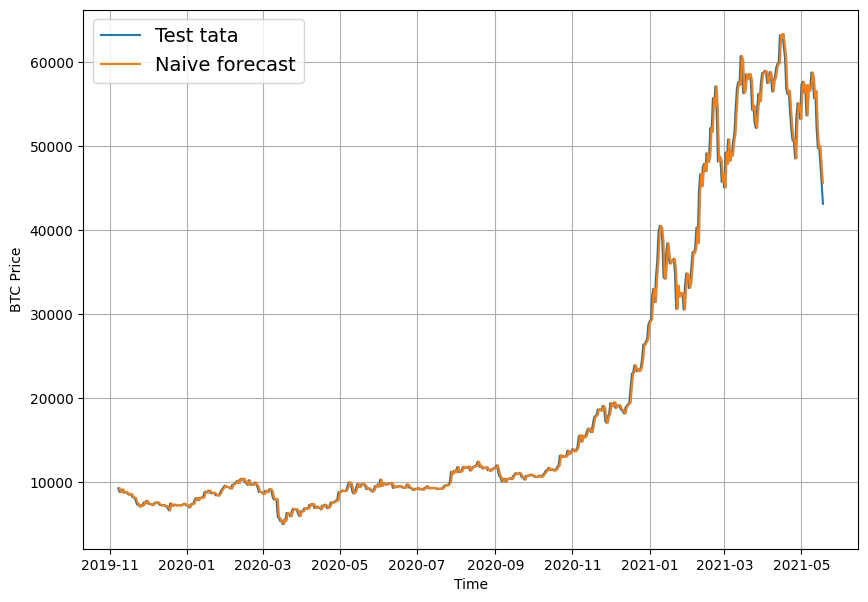

In [67]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
# plot_time_series(X_train, y_train, label="Train tata")
plot_time_series(X_test, y_test, format="-", label="Test tata")
plot_time_series(X_test[1:], naive_forecast, format="-", label="Naive forecast")

## Evaluating a time series model

Common regression metrics:
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root MSE, easier to interpret than MSE
* (s)MAPE - (symmetric) mean absolute percentage error (not advised)
* MASE - mean absolute scaled error - scaled by error of naive forecast

https://otexts.com/fpp3/accuracy.html

https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py

In [68]:
import tensorflow as tf

In [69]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE, assuming no seasonality/seasonality of 1 day
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


In [70]:
mean_absolute_scaled_error(y_test[1:], naive_forecast).numpy()

0.9995699939182624

In [71]:
# Multi-metric function for calculating prediction metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype for metric calculations in order for tf not to spew errors
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_true = tf.cast(y_true, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(), # so that it doesn't return tf tensors
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [72]:
naive_results = evaluate_preds(y_test[1:], naive_forecast)
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Other models that can be used as baselines and actual forecasts

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/?ref=mrdbourke.com#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format data part 2: Windowing the the dataset

So that the model predicts on 7 samples

https://www.uber.com/en-PL/blog/forecasting-introduction/

In [73]:
# Set up global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # based on last week

In [74]:
# Create fcn to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  return x[:,:-horizon], x[:, -horizon:]

In [75]:
# Test out the window labelling fcn
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

Instead of using for loops to convert our data into features and labels, we'll use numpy array indexing for speed

https://numpy.org/doc/stable/user/basics.indexing.html

https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [76]:
import numpy as np

#  Function to window the input data
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1 D array into a 2D arrayof sequential labelled windows of window_size with horizon size labels
  """
  # Create a window of specific size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # Create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  # Use the above to index on the timeseries
  windowed_array = x[window_indexes]
  # Get labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon)

  return windows, labels

# Much much faster than python for loops

In [77]:
full_windows, full_labels = make_windows(prices)
len(full_windows), len(full_labels)

(2780, 2780)

In [78]:
# View first 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i]}, label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ], label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ], label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ], label: [125.96116]


In [79]:
# View last 3 windows w/ labels
for i in range(3):
  print(f"Window: {full_windows[i-3]}, label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], label: [43144.47129086]


Actually you can do all that with just the function `tf.keras.preprocessing.timeseries_dataset_from_array` https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [80]:
# Make train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows)*(1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [82]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

## Make a modelling checkpoint callback

To compare each model's best performances


In [85]:
import os

# Create a fcn to implement a checkpoint callback
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model with window = 7 and horizon = 1

* Single dense layer with 128 neurons and ReLU
* Output layer with linear activation
* Adam optimizer and MAE loss fcn
* Batch size of 128
* 100 epochs

https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=pl

In [87]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducibility
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense_7_1")

# Compile
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="mae",
                metrics=["mae","mse"])

# Fit
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 4s 110ms/step - loss: 2575.9148 - mae: 2575.9148 - mse: 17922942.0000 - val_loss: 5404.8647 - val_mae: 5404.8647 - val_mse: 54062012.0000
Epoch 2/100
18/18 [==============================] - 1s 73ms/step - loss: 403.7234 - mae: 403.7234 - mse: 584552.5000 - val_loss: 1082.9130 - val_mae: 1082.9130 - val_mse: 3922060.0000
Epoch 3/100
18/18 [==============================] - 1s 85ms/step - loss: 222.8635 - mae: 222.8635 - mse: 231874.1562 - val_loss: 1075.6426 - val_mae: 1075.6426 - val_mse: 3873875.0000
Epoch 4/100
18/18 [==============================] - 1s 46ms/step - loss: 190.1501 - mae: 190.1501 - mse: 184668.8906 - val_loss: 1007.6451 - val_mae: 1007.6451 - val_mse: 3420660.0000
Epoch 5/100
18/18 [==============================] - 1s 44ms/step - loss: 177.6002 - mae: 177.6002 - mse: 165671.6250 - val_loss: 971.7703 - val_mae: 971.7703 - val_mse: 3139875.5000
Epoch 6/100
18/18 [==============================] - 1s 47ms/step - los

In [88]:
# Evaluate model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 623.0770 - mae: 623.0770 - mse: 1272344.0000


[623.0770263671875, 623.0770263671875, 1272344.0]

In [89]:
# Load in the saved best performing model
model_1 = tf.keras.models.load_model("/content/model_experiments/model_1_dense_7_1")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 571.7325 - mae: 571.7325 - mse: 1179690.8750


[571.7324829101562, 571.7324829101562, 1179690.875]

In [90]:
naive_results

{'mae': 567.9802183723001,
 'mse': 1147547.0780835983,
 'rmse': 1071.2362382236695,
 'mape': 2.5165248502692306,
 'mase': 0.99957}

## Making forecasts with the model

In [91]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

In [94]:
# Make predictions and view results
model_1_preds = make_preds(model_1, test_windows)
model_1_results = evaluate_preds(tf.squeeze(test_labels), model_1_preds) # tensors of different shapes
model_1_results

18/18 [==============================] - 0s 3ms/step


{'mae': 571.7324,
 'mse': 1179691.2,
 'rmse': 1086.136,
 'mape': 2.5578394,
 'mase': 1.0043755}

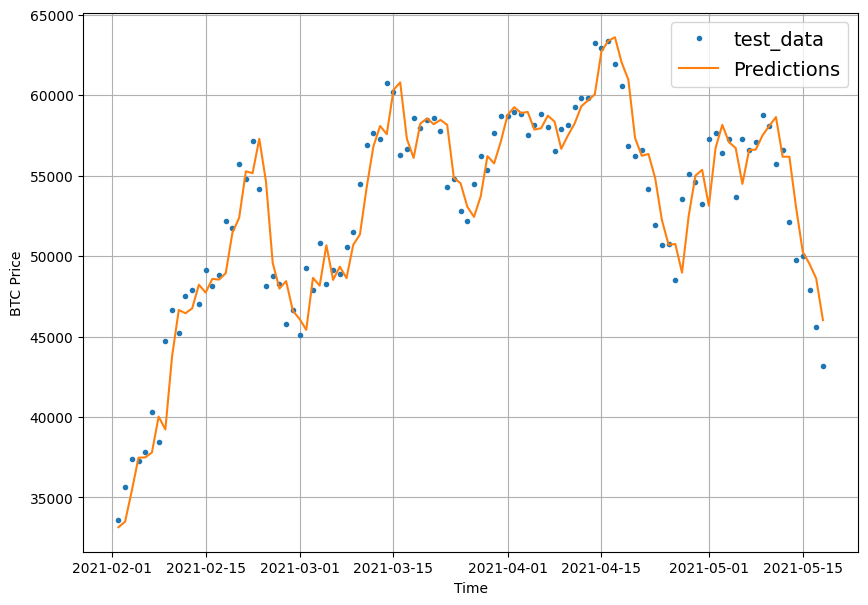

In [102]:
# Plot preds
offset = 450
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="Predictions")

https://en.wikipedia.org/wiki/Autoregressive_model